In [136]:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras import layers
import numpy as np
from tensorflow.python.keras import backend as K
K.clear_session()

In [137]:
latent_dim = 100
height = 28
width = 28
channels = 1
generator_input = tk.Input(shape=(latent_dim,))
x = layers.Dense(7*7*128)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 4, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(1, 5, padding='same')(x)
generator = tk.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_114 (InputLayer)      [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 6272)              633472    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                             

In [138]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(64, 3, strides=2, padding='same')(discriminator_input)
x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(512, 3, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = tk.models.Model(discriminator_input, x)
discriminator.summary()
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_115 (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 512)         1180

In [139]:
discriminator.trainable = False
gan_input = tk.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tk.models.Model(gan_input, gan_output)
gan_optimizer = tf.keras.optimizers.Adam(1e-4)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [140]:
(x_train, y_train), (_, _) = tk.datasets.mnist.load_data()
x_train = x_train[y_train.flatten() == 4]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 127.5

iterations = 1000
batch_size = 128

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    generated_images = generator.predict(random_latent_vectors)

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])

    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    print(step)

4/4 [==============================] - 1s 128ms/step
0
4/4 [==============================] - 1s 127ms/step
1
4/4 [==============================] - 1s 124ms/step
2
4/4 [==============================] - 1s 135ms/step
3
4/4 [==============================] - 0s 121ms/step
4
4/4 [==============================] - 1s 131ms/step
5
4/4 [==============================] - 1s 128ms/step
6
4/4 [==============================] - 1s 128ms/step
7
4/4 [==============================] - 0s 122ms/step
8
4/4 [==============================] - 1s 128ms/step
9
4/4 [==============================] - 1s 122ms/step
10
4/4 [==============================] - 1s 128ms/step
11
4/4 [==============================] - 0s 120ms/step
12
4/4 [==============================] - 1s 144ms/step
13
4/4 [==============================] - 1s 134ms/step
14
4/4 [==============================] - 1s 128ms/step
15
4/4 [==============================] - 1s 153ms/step
16
4/4 [==============================] - 1s 132ms/step
17
4/

4/4 [==============================] - 1s 127ms/step
145
4/4 [==============================] - 1s 135ms/step
146
4/4 [==============================] - 1s 124ms/step
147
4/4 [==============================] - 1s 128ms/step
148
4/4 [==============================] - 1s 139ms/step
149
4/4 [==============================] - 1s 150ms/step
150
4/4 [==============================] - 1s 132ms/step
151
4/4 [==============================] - 1s 132ms/step
152
4/4 [==============================] - 1s 133ms/step
153
4/4 [==============================] - 1s 133ms/step
154
4/4 [==============================] - 1s 128ms/step
155
4/4 [==============================] - 1s 127ms/step
156
4/4 [==============================] - 1s 134ms/step
157
4/4 [==============================] - 1s 132ms/step
158
4/4 [==============================] - 1s 128ms/step
159
4/4 [==============================] - 1s 139ms/step
160
4/4 [==============================] - 1s 129ms/step
161
4/4 [==========================

4/4 [==============================] - 1s 136ms/step
288
4/4 [==============================] - 1s 128ms/step
289
4/4 [==============================] - 1s 131ms/step
290
4/4 [==============================] - 1s 123ms/step
291
4/4 [==============================] - 1s 126ms/step
292
4/4 [==============================] - 1s 121ms/step
293
4/4 [==============================] - 1s 123ms/step
294
4/4 [==============================] - 1s 127ms/step
295
4/4 [==============================] - 1s 125ms/step
296
4/4 [==============================] - 1s 122ms/step
297
4/4 [==============================] - 1s 121ms/step
298
4/4 [==============================] - 1s 131ms/step
299
4/4 [==============================] - 1s 131ms/step
300
4/4 [==============================] - 1s 126ms/step
301
4/4 [==============================] - 1s 128ms/step
302
4/4 [==============================] - 1s 127ms/step
303
4/4 [==============================] - 1s 132ms/step
304
4/4 [==========================

4/4 [==============================] - 1s 129ms/step
431
4/4 [==============================] - 1s 138ms/step
432
4/4 [==============================] - 1s 140ms/step
433
4/4 [==============================] - 1s 136ms/step
434
4/4 [==============================] - 1s 128ms/step
435
4/4 [==============================] - 1s 132ms/step
436
4/4 [==============================] - 1s 127ms/step
437
4/4 [==============================] - 1s 132ms/step
438
4/4 [==============================] - 1s 126ms/step
439
4/4 [==============================] - 1s 128ms/step
440
4/4 [==============================] - 1s 133ms/step
441
4/4 [==============================] - 1s 130ms/step
442
4/4 [==============================] - 1s 128ms/step
443
4/4 [==============================] - 1s 133ms/step
444
4/4 [==============================] - 1s 149ms/step
445
4/4 [==============================] - 1s 137ms/step
446
4/4 [==============================] - 1s 137ms/step
447
4/4 [==========================

4/4 [==============================] - 1s 129ms/step
574
4/4 [==============================] - 1s 133ms/step
575
4/4 [==============================] - 1s 128ms/step
576
4/4 [==============================] - 1s 133ms/step
577
4/4 [==============================] - 1s 142ms/step
578
4/4 [==============================] - 1s 126ms/step
579
4/4 [==============================] - 1s 129ms/step
580
4/4 [==============================] - 1s 132ms/step
581
4/4 [==============================] - 1s 126ms/step
582
4/4 [==============================] - 1s 130ms/step
583
4/4 [==============================] - 1s 132ms/step
584
4/4 [==============================] - 1s 134ms/step
585
4/4 [==============================] - 1s 128ms/step
586
4/4 [==============================] - 1s 131ms/step
587
4/4 [==============================] - 1s 124ms/step
588
4/4 [==============================] - 1s 129ms/step
589
4/4 [==============================] - 1s 133ms/step
590
4/4 [==========================

4/4 [==============================] - 1s 132ms/step
717
4/4 [==============================] - 1s 148ms/step
718
4/4 [==============================] - 1s 135ms/step
719
4/4 [==============================] - 1s 133ms/step
720
4/4 [==============================] - 1s 139ms/step
721
4/4 [==============================] - 1s 128ms/step
722
4/4 [==============================] - 1s 128ms/step
723
4/4 [==============================] - 1s 132ms/step
724
4/4 [==============================] - 1s 129ms/step
725
4/4 [==============================] - 1s 140ms/step
726
4/4 [==============================] - 1s 131ms/step
727
4/4 [==============================] - 1s 130ms/step
728
4/4 [==============================] - 1s 125ms/step
729
4/4 [==============================] - 1s 133ms/step
730
4/4 [==============================] - 1s 155ms/step
731
4/4 [==============================] - 1s 133ms/step
732
4/4 [==============================] - 1s 130ms/step
733
4/4 [==========================

4/4 [==============================] - 1s 135ms/step
860
4/4 [==============================] - 1s 137ms/step
861
4/4 [==============================] - 1s 126ms/step
862
4/4 [==============================] - 1s 128ms/step
863
4/4 [==============================] - 1s 127ms/step
864
4/4 [==============================] - 1s 129ms/step
865
4/4 [==============================] - 1s 132ms/step
866
4/4 [==============================] - 1s 131ms/step
867
4/4 [==============================] - 1s 133ms/step
868
4/4 [==============================] - 1s 134ms/step
869
4/4 [==============================] - 1s 133ms/step
870
4/4 [==============================] - 1s 126ms/step
871
4/4 [==============================] - 1s 133ms/step
872
4/4 [==============================] - 1s 133ms/step
873
4/4 [==============================] - 1s 129ms/step
874
4/4 [==============================] - 1s 138ms/step
875
4/4 [==============================] - 1s 132ms/step
876
4/4 [==========================

1/1 [==============================] - 0s 49ms/step


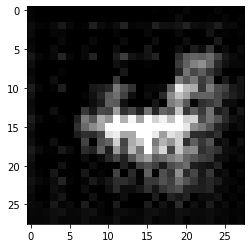

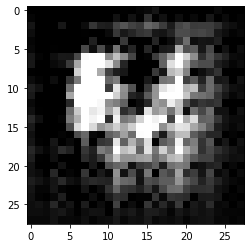

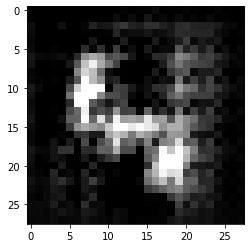

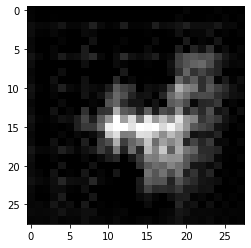

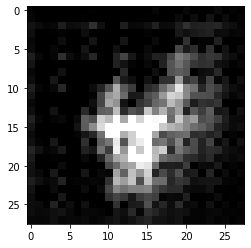

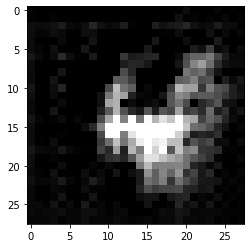

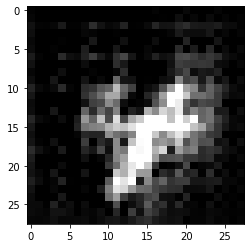

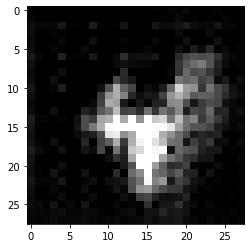

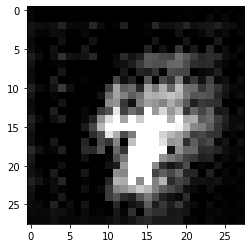

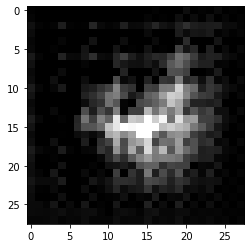

In [170]:
import matplotlib.pyplot as plt
import keras.utils as image
random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = generator.predict(random_latent_vectors)
for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img, cmap='gray')
    
plt.show()